In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# To look at the signals with.
class Scope():
    def __init__(self, sample_freq):
        self.sample_freq = sample_freq
        self.ts = 1 / sample_freq

    def __call__(self, samps):
        fig, ax = plt.subplots()
        ax.grid(True)
        xs = np.arange(len(samps)) * self.ts
        ax.plot(xs, samps)

In [3]:
# Signal generator.
class Sinusoid():
    def __init__(self, sample_freq, freq, amplitude=1.0, phase=0):
        self.sample_freq = sample_freq
        self.ts = 1 / sample_freq
        self.A = amplitude
        self.w = 2 * np.pi * freq
        self.ph = phase
        self.n = 0

    def feed(self):
        r = self.A * np.sin(self.w * self.n * self.ts + self.ph)
        self.n += 1
        return r

    def __call__(self, samps):
        return np.array([self.feed() for i in range(samps)])


In [4]:
def dc(volts, samps):
    return np.ones(shape=samps) * volts

In [5]:
class RC_filter():
    def __init__(self, sample_freq, RC):
        self.k = 1.0 / (RC * sample_freq)
        self.y = 0

    def feed(self, samp):
        self.y += self.k * (samp - self.y)
        return self.y

    def __call__(self, samps):
        return np.array([self.feed(s) for s in samps])

In [6]:
MHz = 1e6
uF = 1e-6
ohms = 1

In [7]:
# From the SoftRock Ensemble II RX.
# With a 50-ohm source, transformer T3 makes it 12.5 ohms,
# then there is a 10-ohm resistor in series, and then the
# resistance of the multiplexer, which is around 4 ohms.
R = 26.5 * ohms
C = 0.047 * uF
f = 10.0 * MHz

# You can vary the phase of the input signal here
# and see the effect on I and Q below.
sgen = Sinusoid(sample_freq=100*f, freq=f, phase=2*np.pi/8)

filt_I = RC_filter(sample_freq=100*f, RC = R * C)
filt_Q = RC_filter(sample_freq=100*f, RC = R * C)

scope = Scope(sample_freq=100*f)

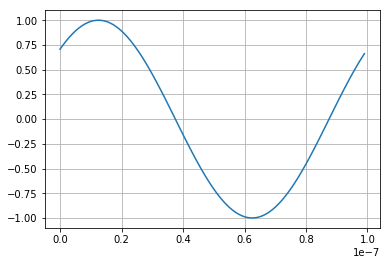

In [8]:
scope(np.concatenate([sgen(25), sgen(25), sgen(25), sgen(25)]))

In [9]:
def cycle():
    "One commutator cycle of the quadrature sampling detector."
    I1 = filt_I(sgen(25))
    Q1 = dc(volts=filt_Q.y, samps=25)
 
    I2 = dc(volts=filt_I.y, samps=25)
    Q2 = filt_Q(sgen(25))

    I3 = filt_I(-sgen(25))
    Q3 = dc(volts=filt_Q.y, samps=25)
 
    I4 = dc(volts=filt_I.y, samps=25)
    Q4 = filt_Q(-sgen(25))

    I = np.concatenate([I1, I2, I3, I4])
    Q = np.concatenate([Q1, Q2, Q3, Q4])
    
    return I, Q

In [10]:
def cycles(n=1):
    "Run commutator for one cycle while showing filter I and Q."
    for i in range(n):
        I, Q = cycle()
    scope(I)
    scope(Q)
    return I,Q

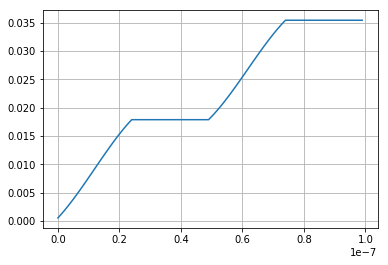

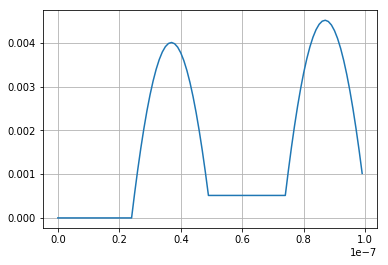

In [11]:
cycles(1);

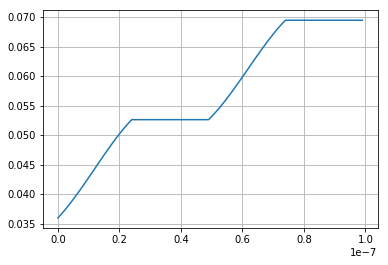

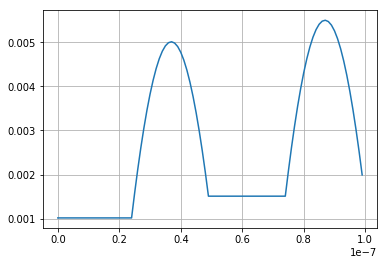

In [12]:
# The second cycle has the same shape but notice that the
# values on the y-axis are different--it is not yet in
# steady state.
cycles(1);

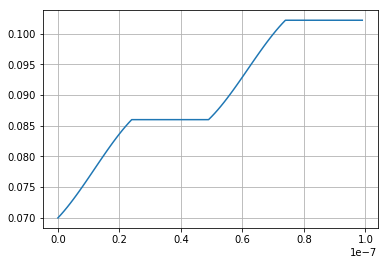

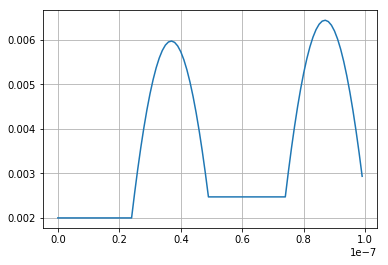

In [13]:
# Again.
cycles(1);

I mean: 0.9000581847113892
Q mean: 0.02705160807829438
magnitude: 0.9004658135691312


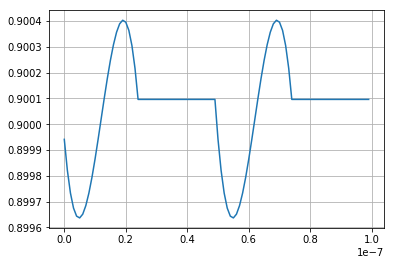

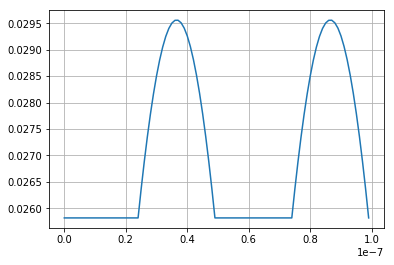

In [14]:
# Now let it run a while and show the last cycle.
I,Q = cycles(500)

print("I mean:", np.mean(I))
print("Q mean:", np.mean(Q))
print("magnitude:", np.sqrt(I*I + Q*Q).mean())

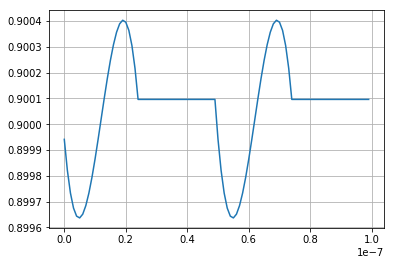

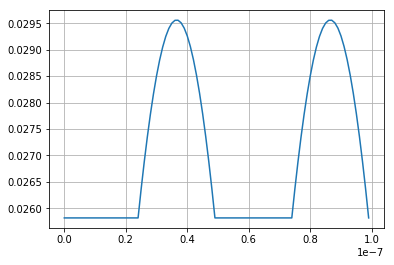

In [15]:
# And verify that this is steady state.
cycles(1);

Notes:
- Here is the [schematic](softrock-bw.pdf).
- For the I component to be truly in phase the received signal needs to be phase delayed by 45 degrees, as done in the signal generator.  This is okay, because there is nothing magic about the phase of the local oscillator--it just starts whenever you turn it on.
- You can see that with this 45-degree phase delay, the I half of the detector is centered on the two peaks, and the Q side of the detector is centered on the two zeros.
- The sound card sees many copies of these single-cycle waveforms during its audio sample.  The average that it sees is indicated in one of the plots.
- The small amount of ripple you see at the detector output passes through the op amp gain stage before being passed on to the sound card, and so the bandwidth there would likely attenuate the ripple some.
-  The amount of ripple is really determined by the source impedance and the sampling capacitor, which is really just a filter capacitor.  You can make it larger and get less ripple, but then you'd increase the time to achieve steady state.  I believe that time is on the order of several time constants for the filter.  With the parts shown, the time constant is about 12.5 microseconds.
- I think this also sets the bandwidth that you have available for sampling with the sound card.  If you have a fancy high-bandwidth sound card these component values might be limiting, but I need to work through that to be sure.  It seems that the bandwidth here might be around 30 kHz on each channel.